## Multiclass Classification using Pytorch

In [557]:
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib.pyplot as plt
import torch

### Prepare Play Dataset

In [558]:
N_SAMPLE = 5000
N_FEATURES = 2
RANDOM_STATE = 42
N_CLASSES = 5
NUM_TRAINING_EPOCHS = 100
X, y = make_blobs(n_samples=N_SAMPLE,
                  n_features=N_FEATURES,
                #   random_state=RANDOM_STATE,
                  centers=N_CLASSES,
                  cluster_std=1.5)

In [559]:
df = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label": y
})
df.head(5)

,X1,X2,label
0,3.146342,-10.413701,0
1,-2.833879,5.128834,1
2,-0.574611,-3.737787,3
3,1.526247,4.608871,1
4,2.329013,-7.982082,0


In [560]:
df.label.value_counts()

label
0    1000
1    1000
3    1000
2    1000
4    1000
Name: count, dtype: int64

In [561]:
### Visualize Data
def plot_circles(x1, x2, labels):
    # plt.figure(figsize=[5,5])
    plt.scatter(
        x=x1, 
        y=x2,
        c=labels,
        s=20
    )
    plt.show()

def plot_circle_df(df):
    plot_circles(df.X1, df.X2, df.label)

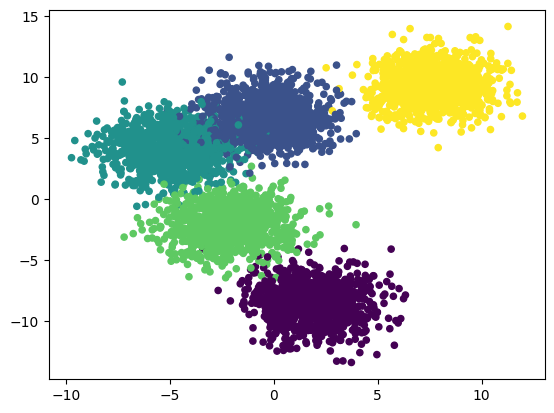

In [578]:
plot_circle_df(df)

### Pytorch Workflow

#### 1. Prepare Dataset (convert inputs to tensors)

In [579]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of X[0]: {X[0].shape}")
print(f"Shape of y[0]: {y[0].shape}")

Shape of X: torch.Size([5000, 2])
Shape of y: torch.Size([5000])
Shape of X[0]: torch.Size([2])
Shape of y[0]: torch.Size([])


In [580]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.long)

TypeError: expected np.ndarray (got Tensor)

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.int64)

In [581]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [582]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: torch.Size([4000, 2])
Shape of y_train: torch.Size([4000])
Shape of X_test: torch.Size([1000, 2])
Shape of y_test: torch.Size([1000])


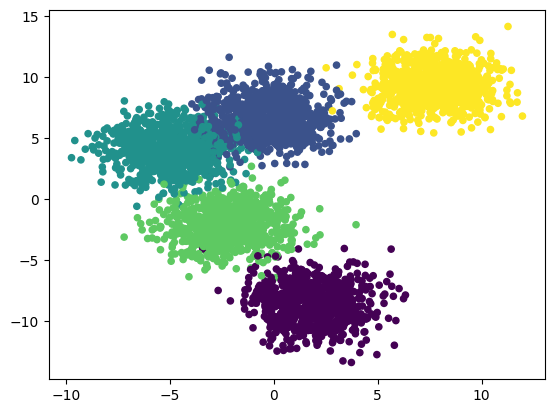

In [583]:
plot_circles(X_train[:, 0], X_train[:, 1], y_train)

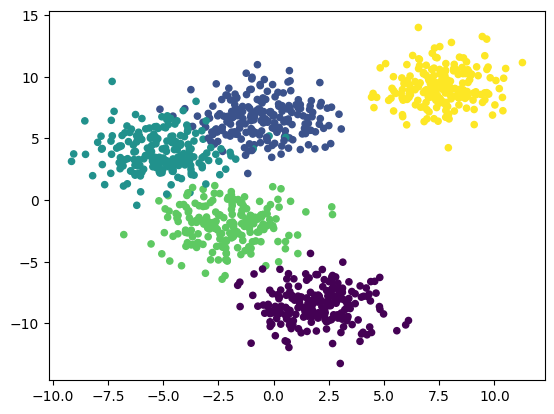

In [584]:
plot_circles(X_test[:, 0], X_test[:, 1], y_test)

#### 2. Build Model

1. Device agnostic code
2. Subclass nn.module
3. Define loss function and optimizer
4. Understand prediction shape
5. Training and Test Loop

In [585]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device", device)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

device cpu


In [626]:
class MultiClassClassifier(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        # self.layers = []
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
           
            nn.Linear(in_features=16, out_features=n_class),
            # nn.Softmax(dim=1), #the CrossEntropyLoss always applies softmax function internally. https://chatgpt.com/s/t_68c93b9c62e48191a2005ec26c93eafb
        )

    def forward(self, x):
        return self.layers(x)

In [627]:
classifier = MultiClassClassifier(N_CLASSES).to(device)
classifier

MultiClassClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=5, bias=True)
  )
)

In [628]:
classifier.eval()
with torch.inference_mode():
    y_logits = classifier(X_test[:3])
y_logits.shape #N,4

torch.Size([3, 5])

So we have to convert logits to probabilities (softmax) and then to prediction (torch.argmax)

In [629]:
classifier.eval()
with torch.inference_mode():
    # Prediction logits
    y_logits = classifier(X_test[:3])

#Probabilities
y_prob = torch.softmax(y_logits, dim=1)
# Prediction Labels
y_prob, y_prob.argmax(dim=1)


(tensor([[0.2131, 0.2067, 0.1361, 0.2453, 0.1988],
         [0.2412, 0.2203, 0.1405, 0.2177, 0.1803],
         [0.2167, 0.1978, 0.1358, 0.2521, 0.1976]]),
 tensor([3, 0, 3]))

In [630]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
    params=classifier.parameters(),
    lr=0.01
)
accuracy_fn = lambda y_pred, y_real: 100*((y_pred == y_real).sum())/len(y_pred)

In [631]:
y_train.dtype

torch.int64

In [632]:
torch.random.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
num_epochs = NUM_TRAINING_EPOCHS
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    classifier.train()
    # Forward
    y_logits = classifier(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # calculate loss
    loss = loss_fn(y_logits, y_train)
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #accuracy metrics
    accuracy = accuracy_fn(y_pred, y_train)
    train_accuracies.append(accuracy.item())
    #Training loop
    classifier.eval()
    with torch.inference_mode():
        y_logits = classifier(X_test).squeeze()
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y_test)
        test_losses.append(loss.item())
        accuracy = accuracy_fn(y_pred, y_test)
        test_accuracies.append(accuracy.item())

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_losses[-1]:.5f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Test Loss: {test_losses[-1]:.5f} | Test Accuracy: {test_accuracies[-1]:.2f}%")

Epoch: 0 | Train Loss: 1.64489 | Train Accuracy: 20.17% | Test Loss: 1.55365 | Test Accuracy: 22.50%
Epoch: 10 | Train Loss: 0.87394 | Train Accuracy: 79.78% | Test Loss: 0.79573 | Test Accuracy: 81.00%
Epoch: 20 | Train Loss: 0.26016 | Train Accuracy: 92.82% | Test Loss: 0.24706 | Test Accuracy: 92.60%
Epoch: 30 | Train Loss: 0.12990 | Train Accuracy: 95.07% | Test Loss: 0.13858 | Test Accuracy: 95.00%
Epoch: 40 | Train Loss: 0.11044 | Train Accuracy: 95.82% | Test Loss: 0.11511 | Test Accuracy: 95.50%
Epoch: 50 | Train Loss: 0.09505 | Train Accuracy: 96.45% | Test Loss: 0.09972 | Test Accuracy: 95.80%
Epoch: 60 | Train Loss: 0.08612 | Train Accuracy: 96.80% | Test Loss: 0.09099 | Test Accuracy: 96.70%
Epoch: 70 | Train Loss: 0.08057 | Train Accuracy: 96.88% | Test Loss: 0.08640 | Test Accuracy: 96.60%
Epoch: 80 | Train Loss: 0.07678 | Train Accuracy: 97.12% | Test Loss: 0.08333 | Test Accuracy: 96.80%
Epoch: 90 | Train Loss: 0.07362 | Train Accuracy: 97.25% | Test Loss: 0.08038 | Tes

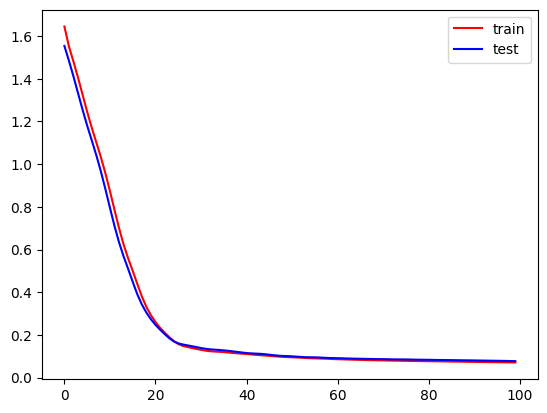

In [633]:
plt.plot(
    train_losses,
    color='r',
    label='train'
    
)
plt.plot(
    test_losses,
    color='b',
    label='test'
)
plt.legend()

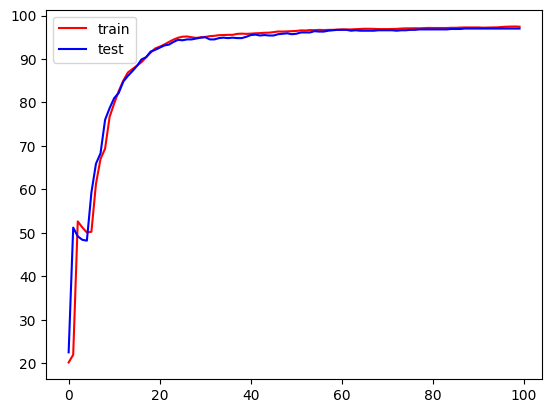

In [634]:
plt.plot(
    train_accuracies,
    color='r',
    label='train'
    
)
plt.plot(
    test_accuracies,
    color='b',
    label='test'
)
plt.legend()

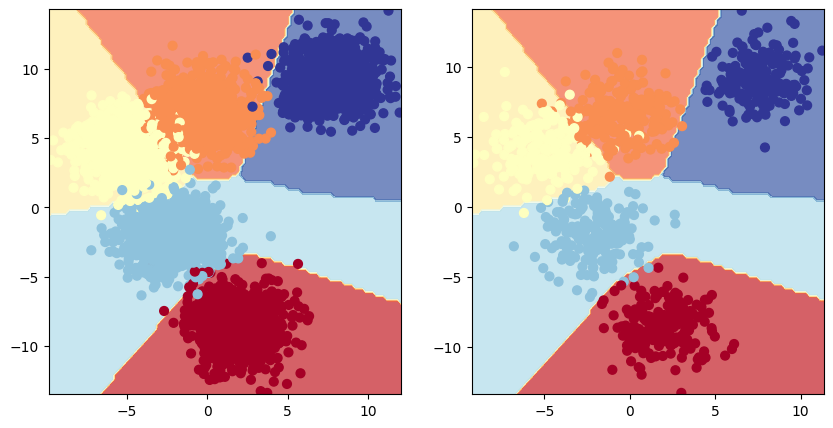

In [635]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plot_decision_boundary(classifier, X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(classifier, X_test, y_test)